**Rotator Trajectory Verification**

This Jupyter notebook is used to verify the updated rotator trajectory generator by Tekniker.
The test will be performed on summit with the real hardware.
Before that, the Tucson test stand is used to develop the test procedure.
The rotator commandable SAL component (CSC) is used to control the rotator hardware.
The published event and telemetry are stored in the engineering facility database (EFD).

It is noted that the **MTMount** telemetry data is required.
If there is none, you need to create the fake data.
Otherwise, the rotator CSC will put the low-level controller into the **Fault** state.

**Import Modules**

In [438]:
%matplotlib inline
import asyncio
import time
from astropy.time import Time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lsst.ts import salobj
from lsst.ts import simactuators
from lsst_efd_client import EfdClient

**Custom Functions**

In [439]:
def retrieve_efd_client(is_summit=True):
    """
    Retrieves a client to EFD.

    Parameters
    ----------
    is_summit : bool, optional
        This notebook is running on the summit or not. If not, the returned object will point
        to the test stand at Tucson.

    Returns
    -------
    EfdClient : The interface object between the Nublado and summit/Tucson EFD.
    """
    efd_name = "summit_efd" if is_summit else "tucson_teststand_efd"        
    return EfdClient(efd_name)

In [440]:
async def print_summary_state(csc):
    """
    Print the summary state of rotator.

    Parameters
    ----------
    csc : lsst.ts.salobj.remote.Remote
        Remote object of the rotator CSC.
    """
    data = await csc.evt_summaryState.aget(timeout=30)
    print(salobj.State(data.summaryState))

In [441]:
async def print_rotator_position(csc):
    """
    Print the rotator position in degree.

    Parameters
    ----------
    csc : lsst.ts.salobj.remote.Remote
        Remote object of the rotator CSC.
    """
    data = await csc.tel_rotation.aget(timeout=15)
    print(f"Rotator is at {data.actualPosition} degree.")

In [442]:
async def print_rotator_latest_message(csc):
    """
    Print the latest message of rotator.

    Parameters
    ----------
    csc : lsst.ts.salobj.remote.Remote
        Remote object of the rotator CSC.
    """
    data = await csc.evt_logMessage.aget(timeout=15)
    print(data.message)

In [443]:
async def create_fake_mtmount_data(mtmount_controller, rotator_csc, period):
    """Create the fake MTMount data for the rotator CSC to subscribe.

    TODO: Remove this workaround method after DM-33967.

    Parameters
    ----------
    mtmount_controller : lsst.ts.salobj.controller.Controller
        MTMount controller object.
    rotator_csc : lsst.ts.salobj.remote.Remote
        Remote object of the rotator CSC.
    period : float
        Period to generate the fake MTMount telemetry data in second.
    """
    # 20 Hz is 0.05 sec
    sleep_time = 0.05

    # Fake the MTMount data in the period
    counts = int(period / sleep_time)

    print("Begin to fake the MTMount telemetry.")
    for count in range(0, counts):
        data = await rotator_csc.tel_rotation.aget(timeout=1)
        mtmount_controller.tel_cameraCableWrap.set_put(
            actualPosition=data.actualPosition,
            actualVelocity=data.actualVelocity,
            timestamp=data.timestamp,
        )
        await asyncio.sleep(sleep_time)

    print("Finish the faking of MTMount telemetry.")

In [444]:
def task_create_fake_mtmount_data(mtmount_controller, rotator_csc, period):
    """Task to create the fake MTMount data for the rotator CSC to subscribe in the background.

    TODO: Remove this workaround method after DM-33967.

    Parameters
    ----------
    mtmount_controller : lsst.ts.salobj.controller.Controller
        MTMount controller object.
    rotator_csc : lsst.ts.salobj.remote.Remote
        Remote object of the rotator CSC.
    period : float
        Period to generate the fake MTMount telemetry data in second.
    """
    asyncio.create_task(create_fake_mtmount_data(mtmount_controller, rotator_csc, period))

In [445]:
def get_time():
    """Get the time object used to query the EFD.

    Returns
    -------
    astropy.time.core.Time
        Time object.
    """
    time_str = time.strftime("%Y-%m-%dT%H:%M:%S", time.gmtime())
    return Time(time_str, scale="utc", format="isot")

In [446]:
def print_and_get_time():
    """Print and get the time object used to query the EFD.

    Returns
    -------
    astropy.time.core.Time
        Time object.
    """
    time = get_time()
    print(f"Time is {time} right now.")

    return time

In [447]:
def generate_tracking_target(position, velocity, period):
    """
    Generate the tracking target.

    Parameters
    ----------
    position : float
        Initial position of target in deg.
    velocity : float
        Velocity of the target in deg/sec.
    period : float
        Period to track in second.

    Returns
    -------
    list_position : list
        List of the position.
    list_velocity : list
        List of the velocity.
    """
    # 20 Hz is 0.05 s
    delta_t = 0.05
    number_total_commands = int(period / delta_t)
    
    list_position = [position + velocity * idx for idx in range(0, number_total_commands)]
    list_velocity = [velocity] *  number_total_commands
    return list_position, list_velocity

In [11]:
async def slew_test(csc, position, est_time_wait, est_time_stop):
    """
    Slew test. The rototator will move in the positive and negative directions.
    It will stop in the final movement.

    Parameters
    ----------
    csc : lsst.ts.salobj.remote.Remote
        Remote object of the rotator CSC.
    est_time_wait : float
        Estimated time to wait of movement in second.
    est_time_stop : float
        Estimated time to stop in the final in second.
    """
    # Move in one direction
    await csc.cmd_move.set_start(position=position, timeout=60)
    await asyncio.sleep(est_time_wait)

    # Move back to the origin
    await csc.cmd_move.set_start(position=0, timeout=60)
    await asyncio.sleep(est_time_wait)

    # Move to the other direction
    await csc.cmd_move.set_start(position=-position, timeout=60)
    await asyncio.sleep(est_time_wait)

    # Move and stop before the end of movement
    await csc.cmd_move.set_start(position=position, timeout=60)
    await asyncio.sleep(est_time_stop)
    await csc.cmd_stop.set_start(timeout=60)

In [448]:
async def track_target(csc, start_position, end_position, velocity):
    """Track the target.

    Parameters
    ----------
    start_position : float
        Starting position of ramp (deg).
    end_position : float
        Ending position of ramp (deg).
    velocity : float
        Velocity of motion along the ramp (deg/sec).
    """
    # 20 Hz is 0.05 ms
    track_advance_time = 0.05
    ramp_generator = simactuators.RampGenerator(
        [start_position], [end_position], [velocity], track_advance_time)

    await csc.cmd_trackStart.start(timeout=15)
    for positions, velocities, tai in ramp_generator():
        await csc.cmd_track.set_start(
            angle=positions[0],
            velocity=velocities[0],
            tai=tai,
            timeout=5,
        )
        await asyncio.sleep(0.1)

In [507]:
async def track_slew_test(csc):
    """
    Track slew sequence test.

    Parameters
    ----------
    csc : lsst.ts.salobj.remote.Remote
        Remote object of the rotator CSC.
    """
    # 20 Hz is 0.05 ms
    track_advance_time = 0.05
    ramp_generator_1 = simactuators.RampGenerator([0.7], [1.5], [0.068], track_advance_time)
    ramp_generator_2 = simactuators.RampGenerator([0.7], [0], [-0.068], track_advance_time)
    ramp_generator_3 = simactuators.RampGenerator([5], [4.7], [-0.01], track_advance_time)
    ramp_generator_4 = simactuators.RampGenerator([-5], [-4.6], [0.0042], track_advance_time)

    # Track the first target
    await csc.cmd_trackStart.start(timeout=15)

    is_stopped = False
    time_start = time.monotonic()
    for positions, velocities, tai in ramp_generator_1():
        await csc.cmd_track.set_start(
            angle=positions[0],
            velocity=velocities[0],
            tai=tai,
            timeout=5,
        )
        await asyncio.sleep(0.1)

        # Stop the rotator in the tracking
        delta_time = time.monotonic() - time_start
        if (3 <= delta_time <= 3.5) and (not is_stopped):
            await csc.cmd_stop.set_start(timeout=10)
            
            await asyncio.sleep(1)
            is_stopped = True

        # Allow the tracking again
        if is_stopped:
            await csc.cmd_trackStart.start(timeout=15)
            is_stopped = False

    # Track the second target
    for positions, velocities, tai in ramp_generator_2():
        await csc.cmd_track.set_start(
            angle=positions[0],
            velocity=velocities[0],
            tai=tai,
            timeout=5,
        )
        await asyncio.sleep(0.1)

    # Track the third target
    for positions, velocities, tai in ramp_generator_3():
        await csc.cmd_track.set_start(
            angle=positions[0],
            velocity=velocities[0],
            tai=tai,
            timeout=5,
        )
        await asyncio.sleep(0.1)

    # Track the fourth target
    for positions, velocities, tai in ramp_generator_4():
        await csc.cmd_track.set_start(
            angle=positions[0],
            velocity=velocities[0],
            tai=tai,
            timeout=5,
        )
        await asyncio.sleep(0.1)

In [492]:
async def slew_supersession_test(csc):
    """
    Slew supersession test.

    Parameters
    ----------
    csc : lsst.ts.salobj.remote.Remote
        Remote object of the rotator CSC.
    """
    # 20 Hz is 0.05 ms
    track_advance_time = 0.05
    ramp_generator_1 = simactuators.RampGenerator([60], [62], [0.068], track_advance_time)
    ramp_generator_2 = simactuators.RampGenerator([-60], [-62], [-0.05], track_advance_time)

    # Track the first target
    await csc.cmd_trackStart.start(timeout=15)

    is_stopped = False
    time_start = time.monotonic()
    for positions, velocities, tai in ramp_generator_1():
        await csc.cmd_track.set_start(
            angle=positions[0],
            velocity=velocities[0],
            tai=tai,
            timeout=5,
        )
        await asyncio.sleep(0.1)

        # Break the tracking of this target to test the supersession of slew
        if (time.monotonic() - time_start) > 8:
            break

    # Track the second target
    for positions, velocities, tai in ramp_generator_2():
        await csc.cmd_track.set_start(
            angle=positions[0],
            velocity=velocities[0],
            tai=tai,
            timeout=5,
        )
        await asyncio.sleep(0.1)

In [13]:
async def track_slew_multiple_stop_test(csc):
    """
    Track slew sequence test with multiple stops.

    Parameters
    ----------
    csc : lsst.ts.salobj.remote.Remote
        Remote object of the rotator CSC.
    """
    # 20 Hz is 0.05 ms
    track_advance_time = 0.05
    ramp_generator_1 = simactuators.RampGenerator([0.7], [1.5], [0.068], track_advance_time)
    ramp_generator_2 = simactuators.RampGenerator([0.7], [0], [-0.068], track_advance_time)

    # Track the first target
    await csc.cmd_trackStart.start(timeout=15)

    is_stopped = False
    time_start = time.monotonic()
    for positions, velocities, tai in ramp_generator_1():
        await csc.cmd_track.set_start(
            angle=positions[0],
            velocity=velocities[0],
            tai=tai,
            timeout=5,
        )
        await asyncio.sleep(0.1)

        # Stop the rotator in the tracking
        delta_time = time.monotonic() - time_start
        if ((3 <= delta_time <= 3.5) or (6 <= delta_time <= 6.5)) and (not is_stopped):
            await csc.cmd_stop.set_start(timeout=10)
            
            await asyncio.sleep(1)
            is_stopped = True

        # Allow the tracking again
        if is_stopped:
            await csc.cmd_trackStart.start(timeout=15)
            is_stopped = False

    # Track the second target
    for positions, velocities, tai in ramp_generator_2():
        await csc.cmd_track.set_start(
            angle=positions[0],
            velocity=velocities[0],
            tai=tai,
            timeout=5,
        )
        await asyncio.sleep(0.1)

In [450]:
async def plot_path_generator(efd_client, time_start, time_end):
    """
    Plot the data of path generator.

    Parameters
    ----------
    efd_client : lsst_efd_client.efd_helper.EfdClient
        EFD client.
    time_start : astropy.time.core.Time
        Start time.
    time_end : astropy.time.core.Time
        End time.
    """
    # Get the data from EFD
    data = await efd_client.select_time_series(
        "lsst.sal.MTRotator.rotation", 
        fields=["demandPosition", "demandVelocity", "demandAcceleration", "actualPosition", "actualVelocity", "timestamp"], 
        start=time_start, 
        end=time_end)

    # Realign the time origin to 0
    time_operation = np.array(data.timestamp.subtract(data.timestamp[0]))

    # Plots
    plt.subplot(3, 1, 1)
    plt.plot(time_operation, data.demandPosition)
    plt.plot(time_operation, data.actualPosition, "x-")
    plt.title("Path Generator")
    plt.ylabel("P (deg)")

    plt.subplot(3, 1, 2)
    plt.plot(time_operation, data.demandVelocity)
    plt.plot(time_operation, data.actualVelocity, "x-")
    plt.ylabel("V (deg/s)")

    plt.subplot(3, 1, 3)
    plt.plot(time_operation, data.demandAcceleration)
    plt.xlabel("Time (s)")
    plt.ylabel("A (deg/s^2)")

In [329]:
async def get_event_data(efd_client, time_start, time_end):
    """
    Get the event data.

    Parameters
    ----------
    efd_client : lsst_efd_client.efd_helper.EfdClient
        EFD client.
    time_start : astropy.time.core.Time
        Start time.
    time_end : astropy.time.core.Time
        End time.

    Returns
    -------
    data_controller_state : pandas.core.frame.DataFrame
        Data of the controller state event.
    data_in_position : pandas.core.frame.DataFrame
        Data of the inPosition event.
    data_tracking : pandas.core.frame.DataFrame
        Data of the tracking event.
    """

    # Get the data from EFD
    data_controller_state = await efd_client.select_time_series(
        "lsst.sal.MTRotator.logevent_controllerState", 
        fields=["controllerState", "enabledSubstate"], 
        start=time_start,
        end=time_end)
    data_in_position = await efd_client.select_time_series(
        "lsst.sal.MTRotator.logevent_inPosition", 
        fields="inPosition",
        start=time_start,
        end=time_end)
    data_tracking = await efd_client.select_time_series(
        "lsst.sal.MTRotator.logevent_tracking", 
        fields=["tracking", "lost", "noNewCommand"],
        start=time_start,
        end=time_end)

    # Add the column of time difference in seconds
    add_column_time_differece(data_controller_state, time_start)
    add_column_time_differece(data_in_position, time_start)
    add_column_time_differece(data_tracking, time_start)

    return data_controller_state, data_in_position, data_tracking

In [451]:
def add_column_time_differece(data_frame, time_start):
    """
    Add the column of time difference in second.

    Parameters
    ----------
    data_frame : pandas.core.frame.DataFrame
        Data frame.
    time_start : astropy.time.core.Time
        Start time.
    """
    if (len(data_frame.values) != 0):
        timestamp_start = pd.Timestamp(time_start.value, tz="utc")
        diff_time = data_frame.index - pd.Timestamp(time_start.value, tz="utc")
        diff_time_sec = [element.seconds + element.microseconds * 1e-6 for element in diff_time]
        data_frame["time_difference"] = diff_time_sec

**Instantiate the EFD and CSC**

Need to make sure **ospl** is running for the data distribution system (DDS) communication.

In [452]:
efd_client = retrieve_efd_client(is_summit=False)
rotator = salobj.Remote(salobj.Domain(), "MTRotator")
await rotator.start_task
await rotator.cmd_setLogLevel.set_start(level=10)

**MTMount** controller is used to generate the fake data if needed.

In [462]:
# Run the following code if there is the problem of MTMount to follow the rotator

# mtmount_controller = salobj.Controller("MTMount")
# await mtmount_controller.start_task

Put the rotator CSC into **Enabled** state before the test.
At this moment, we need to do the workaround before DM-33967.
At Tucson teststand, we can use *tts_test.yaml* to workaround the following error of rotator and camera cable wrapper (CCW).

In [460]:
# Run the following code if there is the problem of MTMount to follow the rotator

# await salobj.set_summary_state(rotator, salobj.State.DISABLED, timeout=30)
# task_create_fake_mtmount_data(mtmount_controller, rotator, 240)
# await asyncio.sleep(2)
# await salobj.set_summary_state(rotator, salobj.State.ENABLED, timeout=30)

In [526]:
# "tts_test.yaml" is the configuration file at Tucson teststand to increase the tolerance in the
# difference between the rotator and CCW 
await salobj.set_summary_state(
    rotator, salobj.State.ENABLED,
    timeout=30,
    settingsToApply="tts_test.yaml"
)

[<State.FAULT: 3>, <State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

**Check the rotator condition**

After each test case, execute this cell to get the **time_now**, which is used in the query of EFD data.

In [520]:
time_now = print_and_get_time()

await print_rotator_position(rotator)
await print_summary_state(rotator)
await print_rotator_latest_message(rotator)

Time is 2022-03-09T17:31:11.000 right now.
Rotator is at -4.600001218763845 degree.
State.FAULT
Fault! errorCode=1, errorReport='Low-level controller went to FAULT state'


**Put the rotator back to origin**

Before each test, put the rotator back to origin.
This is easier for the data analysis.

In [516]:
await rotator.cmd_move.set_start(position=0, timeout=60)

**Test Case (small slewing test)**

Test the positive and negative directions.

In [212]:
time_start = print_and_get_time()
await slew_test(rotator, 0.7, 2, 0.1)

Time is 2022-03-09T13:38:20.000 right now.


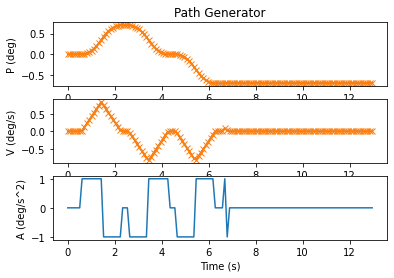

In [225]:
await plot_path_generator(efd_client, time_start, time_now)

In [226]:
data_controller_state, data_in_position, data_tracking = await get_event_data(
    efd_client, time_start, time_now)

In [231]:
data_controller_state

,controllerState,enabledSubstate,time_difference
2022-03-09 13:38:20.648000+00:00,2,1,0.648
2022-03-09 13:38:22.173000+00:00,2,0,2.173
2022-03-09 13:38:22.677000+00:00,2,1,2.677
2022-03-09 13:38:24.193000+00:00,2,0,4.193
2022-03-09 13:38:24.698000+00:00,2,1,4.698
2022-03-09 13:38:26.216000+00:00,2,0,6.216
2022-03-09 13:38:26.723000+00:00,2,1,6.723
2022-03-09 13:38:26.825000+00:00,2,0,6.825


In [232]:
data_in_position

,inPosition,time_difference
2022-03-09 13:38:22.174000+00:00,True,2.174
2022-03-09 13:38:22.275000+00:00,False,2.275
2022-03-09 13:38:24.194000+00:00,True,4.194
2022-03-09 13:38:24.296000+00:00,False,4.296
2022-03-09 13:38:26.217000+00:00,True,6.217
2022-03-09 13:38:26.319000+00:00,False,6.319


In [233]:
data_tracking

""


**Test Case (long slew test + constant speed test)**

Test the positive and negative directions.
The behavior of trajectory generator should be the same for these two tests.
Note the CSC does not support the command of constant speed move.

In [239]:
time_start = print_and_get_time()
await slew_test(rotator, 90, 35, 10)

Time is 2022-03-09T13:53:01.000 right now.


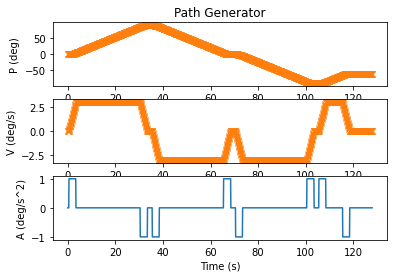

In [241]:
await plot_path_generator(efd_client, time_start, time_now)

In [242]:
data_controller_state, data_in_position, data_tracking = await get_event_data(
    efd_client, time_start, time_now)

In [243]:
data_controller_state

,controllerState,enabledSubstate,time_difference
2022-03-09 13:53:01.605000+00:00,2,1,0.605
2022-03-09 13:53:34.402000+00:00,2,0,33.402
2022-03-09 13:53:36.637000+00:00,2,1,35.637
2022-03-09 13:54:09.416000+00:00,2,0,68.416
2022-03-09 13:54:11.644000+00:00,2,1,70.644
2022-03-09 13:54:44.417000+00:00,2,0,103.417
2022-03-09 13:54:46.638000+00:00,2,1,105.638
2022-03-09 13:54:56.649000+00:00,2,0,115.649


In [244]:
data_in_position

,inPosition,time_difference
2022-03-09 13:53:34.403000+00:00,True,33.403
2022-03-09 13:53:34.504000+00:00,False,33.504
2022-03-09 13:54:09.417000+00:00,True,68.417
2022-03-09 13:54:09.517000+00:00,False,68.517
2022-03-09 13:54:44.418000+00:00,True,103.418
2022-03-09 13:54:44.519000+00:00,False,103.519


In [245]:
data_tracking

""


Finish the faking of MTMount telemetry.


**Test Case (rotation range test)**

Note the CSC does not support the command of constant speed move.

In [293]:
# Test the move position is out of range
time_start = print_and_get_time()

try:
    await rotator.cmd_move.set_start(position=91, timeout=60)
except salobj.AckError as error:
    print(error)

try:
    await rotator.cmd_move.set_start(position=-91, timeout=60)
except salobj.AckError as error:
    print(error)

Time is 2022-03-08T17:26:00.000 right now
msg='Command failed', ackcmd=(ackcmd private_seqNum=1021312672, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result='Failed: position 91.0 not in range [-90.0, 90.0]')
msg='Command failed', ackcmd=(ackcmd private_seqNum=1021312673, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result='Failed: position -91.0 not in range [-90.0, 90.0]')


In [ ]:
await plot_path_generator(efd_client, time_start, time_now)

In [ ]:
data_controller_state, data_in_position, data_tracking = await get_event_data(
    efd_client, time_start, time_now)

In [ ]:
data_controller_state

In [ ]:
data_in_position

In [ ]:
data_tracking

**Test Case (position accuracy)**

The **slewingAndTracking** operation will be tested.
Note the rotator will transition to Fault state in the final if there is no new track command.
This behaviour can be used to verify the test case of "no tracking commands".
In addition, the trajectory generator will do the extrapolation in a small time period before the transition to **Fault** state.

Target is moving in the positive direction.

In [252]:
time_start = print_and_get_time()
await track_target(rotator, 30, 30.5, 0.03)

Time is 2022-03-09T14:04:27.000 right now.


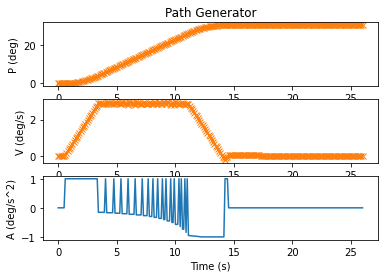

In [255]:
await plot_path_generator(efd_client, time_start, time_now)

In [256]:
data_controller_state, data_in_position, data_tracking = await get_event_data(
    efd_client, time_start, time_now)

In [257]:
data_controller_state

,controllerState,enabledSubstate,time_difference
2022-03-09 14:04:27.612000+00:00,2,2,0.612
2022-03-09 14:04:45.696000+00:00,4,0,18.696


In [258]:
data_in_position

,inPosition,time_difference
2022-03-09 14:04:41.457000+00:00,True,14.457
2022-03-09 14:04:45.697000+00:00,False,18.697


In [259]:
data_tracking

,tracking,lost,noNewCommand,time_difference
2022-03-09 14:04:41.458000+00:00,True,False,False,14.458
2022-03-09 14:04:45.697000+00:00,False,False,True,18.697


Finish the faking of MTMount telemetry.


Target is moving in the negative direction.

In [264]:
time_start = print_and_get_time()
await track_target(rotator, -30, -31.1, -0.068)

Time is 2022-03-09T14:16:30.000 right now.


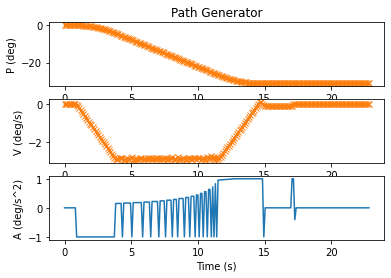

In [266]:
await plot_path_generator(efd_client, time_start, time_now)

In [267]:
data_controller_state, data_in_position, data_tracking = await get_event_data(
    efd_client, time_start, time_now)

In [268]:
data_controller_state

,controllerState,enabledSubstate,time_difference
2022-03-09 14:16:30.997000+00:00,2,2,0.997
2022-03-09 14:16:48.572000+00:00,4,0,18.572


In [269]:
data_in_position

,inPosition,time_difference
2022-03-09 14:16:44.127000+00:00,True,14.127
2022-03-09 14:16:44.227000+00:00,False,14.227
2022-03-09 14:16:45.036000+00:00,True,15.036
2022-03-09 14:16:48.573000+00:00,False,18.573


In [270]:
data_tracking

,tracking,lost,noNewCommand,time_difference
2022-03-09 14:16:44.127000+00:00,True,False,False,14.127
2022-03-09 14:16:44.227000+00:00,False,False,False,14.227
2022-03-09 14:16:45.036000+00:00,True,False,False,15.036
2022-03-09 14:16:48.573000+00:00,False,False,True,18.573


Finish the faking of MTMount telemetry.


**Test Case (tracking / slewing sequence test)**

Track two targets and stop in between.

In [518]:
time_start = print_and_get_time()
await track_slew_test(rotator)

Time is 2022-03-09T17:28:38.000 right now.


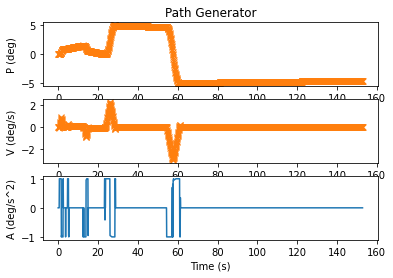

In [521]:
await plot_path_generator(efd_client, time_start, time_now)

In [522]:
data_controller_state, data_in_position, data_tracking = await get_event_data(
    efd_client, time_start, time_now)

In [523]:
data_controller_state

,controllerState,enabledSubstate,time_difference
2022-03-09 17:28:38.695000+00:00,2,2,0.695
2022-03-09 17:28:41.823000+00:00,2,0,3.823
2022-03-09 17:28:42.833000+00:00,2,2,4.833
2022-03-09 17:31:09.290000+00:00,4,0,151.290


In [524]:
data_in_position

,inPosition,time_difference
2022-03-09 17:28:40.411000+00:00,True,2.411
2022-03-09 17:28:41.824000+00:00,False,3.824
2022-03-09 17:28:43.340000+00:00,True,5.340
2022-03-09 17:28:51.111000+00:00,False,13.111
2022-03-09 17:28:52.827000+00:00,True,14.827
2022-03-09 17:29:01.909000+00:00,False,23.909
2022-03-09 17:29:06.753000+00:00,True,28.753
2022-03-09 17:29:32.581000+00:00,False,54.581
2022-03-09 17:29:39.246000+00:00,True,61.246
2022-03-09 17:31:09.291000+00:00,False,151.291


In [525]:
data_tracking

,tracking,lost,noNewCommand,time_difference
2022-03-09 17:28:40.411000+00:00,True,False,False,2.411
2022-03-09 17:28:41.824000+00:00,False,False,False,3.824
2022-03-09 17:28:43.340000+00:00,True,False,False,5.340
2022-03-09 17:28:51.112000+00:00,False,False,False,13.112
2022-03-09 17:28:52.827000+00:00,True,False,False,14.827
2022-03-09 17:29:01.909000+00:00,False,False,False,23.909
2022-03-09 17:29:06.753000+00:00,True,False,False,28.753
2022-03-09 17:29:32.581000+00:00,False,False,False,54.581
2022-03-09 17:29:39.246000+00:00,True,False,False,61.246
2022-03-09 17:31:09.291000+00:00,False,False,True,151.291


**Test Case (tracking without initial slewing)**

No initial slewing is applied to the rotator.

In [349]:
time_start = print_and_get_time()

data = await rotator.tel_rotation.aget(timeout=15)
await track_target(rotator, data.actualPosition, data.actualPosition + 0.5, 0.068)

Time is 2022-03-09T14:52:33.000 right now.


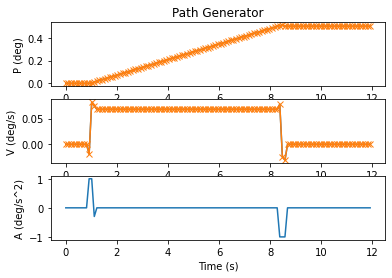

In [352]:
await plot_path_generator(efd_client, time_start, time_now)

In [353]:
data_controller_state, data_in_position, data_tracking = await get_event_data(
    efd_client, time_start, time_now)

In [354]:
data_controller_state

,controllerState,enabledSubstate,time_difference
2022-03-09 14:52:33.963000+00:00,2,2,0.963
2022-03-09 14:52:42.840000+00:00,4,0,9.840


In [355]:
data_in_position

,inPosition,time_difference
2022-03-09 14:52:33.964000+00:00,True,0.964
2022-03-09 14:52:42.841000+00:00,False,9.841


In [356]:
data_tracking

,tracking,lost,noNewCommand,time_difference
2022-03-09 14:52:33.964000+00:00,True,False,False,0.964
2022-03-09 14:52:42.841000+00:00,False,False,True,9.841


Finish the faking of MTMount telemetry.


**Test Case (slewing supersession)**

Test the slewing supersession capability of the rotator.

In [493]:
time_start = print_and_get_time()
await slew_supersession_test(rotator)

Time is 2022-03-09T17:17:37.000 right now.


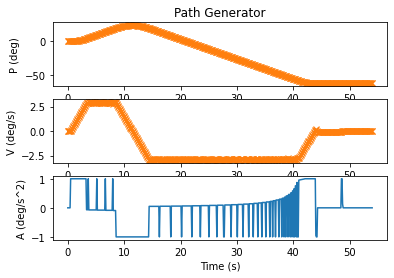

In [501]:
await plot_path_generator(efd_client, time_start, time_now)

In [502]:
data_controller_state, data_in_position, data_tracking = await get_event_data(
    efd_client, time_start, time_now)

In [503]:
data_controller_state

,controllerState,enabledSubstate,time_difference
2022-03-09 17:17:37.505000+00:00,2,2,0.505
2022-03-09 17:18:26.958000+00:00,4,0,49.958


In [504]:
data_in_position

,inPosition,time_difference
2022-03-09 17:18:21.108000+00:00,True,44.108
2022-03-09 17:18:26.959000+00:00,False,49.959


In [505]:
data_tracking

,tracking,lost,noNewCommand,time_difference
2022-03-09 17:18:21.108000+00:00,True,False,False,44.108
2022-03-09 17:18:26.959000+00:00,False,False,True,49.959


**Test Case (minimum tracking speed)**

In [418]:
time_start = print_and_get_time()
await track_target(rotator, 0.7, 0.8, 0.0042)

Time is 2022-03-09T15:33:13.000 right now.


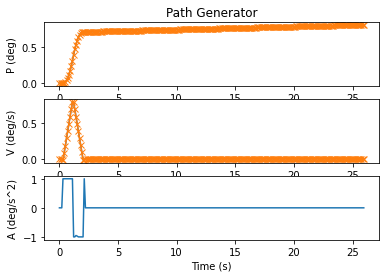

In [421]:
await plot_path_generator(efd_client, time_start, time_now)

In [422]:
data_controller_state, data_in_position, data_tracking = await get_event_data(
    efd_client, time_start, time_now)

In [423]:
data_controller_state

,controllerState,enabledSubstate,time_difference
2022-03-09 15:33:13.305000+00:00,2,2,0.305
2022-03-09 15:33:38.655000+00:00,4,0,25.655


In [424]:
data_in_position

,inPosition,time_difference
2022-03-09 15:33:14.919000+00:00,True,1.919
2022-03-09 15:33:38.656000+00:00,False,25.656


In [425]:
data_tracking

,tracking,lost,noNewCommand,time_difference
2022-03-09 15:33:14.919000+00:00,True,False,False,1.919
2022-03-09 15:33:38.656000+00:00,False,False,True,25.656


Finish the faking of MTMount telemetry.
Finish the faking of MTMount telemetry.


**Test Case (tracking / slewing with multiple stops)**

In [430]:
time_start = print_and_get_time()
await track_slew_multiple_stop_test(rotator)

Time is 2022-03-09T15:41:01.000 right now.


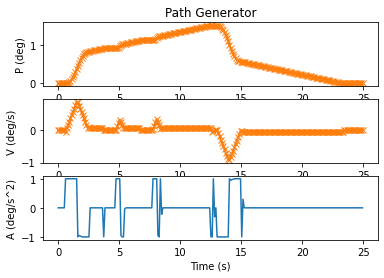

In [433]:
await plot_path_generator(efd_client, time_start, time_now)

In [434]:
data_controller_state, data_in_position, data_tracking = await get_event_data(
    efd_client, time_start, time_now)

In [435]:
data_controller_state

,controllerState,enabledSubstate,time_difference
2022-03-09 15:41:01.648000+00:00,2,2,0.648
2022-03-09 15:41:04.775000+00:00,2,0,3.775
2022-03-09 15:41:05.784000+00:00,2,2,4.784
2022-03-09 15:41:07.805000+00:00,2,0,6.805
2022-03-09 15:41:08.813000+00:00,2,2,7.813
2022-03-09 15:41:25.877000+00:00,4,0,24.877


In [436]:
data_in_position

,inPosition,time_difference
2022-03-09 15:41:03.363000+00:00,True,2.363
2022-03-09 15:41:04.776000+00:00,False,3.776
2022-03-09 15:41:06.290000+00:00,True,5.290
2022-03-09 15:41:07.806000+00:00,False,6.806
2022-03-09 15:41:09.318000+00:00,True,8.318
2022-03-09 15:41:14.064000+00:00,False,13.064
2022-03-09 15:41:15.782000+00:00,True,14.782
2022-03-09 15:41:25.878000+00:00,False,24.878


In [437]:
data_tracking

,tracking,lost,noNewCommand,time_difference
2022-03-09 15:41:03.363000+00:00,True,False,False,2.363
2022-03-09 15:41:04.776000+00:00,False,False,False,3.776
2022-03-09 15:41:06.290000+00:00,True,False,False,5.290
2022-03-09 15:41:07.806000+00:00,False,False,False,6.806
2022-03-09 15:41:09.318000+00:00,True,False,False,8.318
2022-03-09 15:41:14.064000+00:00,False,False,False,13.064
2022-03-09 15:41:15.782000+00:00,True,False,False,14.782
2022-03-09 15:41:25.878000+00:00,False,False,True,24.878


Finish the faking of MTMount telemetry.
